# *Rossmann store sales* - a kaggle data set
 historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column.                                                                  
 Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE).

Importing the nessesary packges

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggel/Rossmann Store Sales/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/kaggel/Rossmann Store Sales/test.csv')
store_df= pd.read_csv('/content/drive/MyDrive/kaggel/Rossmann Store Sales/store.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [70]:
train_df.shape

(1017209, 9)

In [79]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [80]:
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [44]:
store_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270.0,570.0,14130.0,620.0,29910.0
CompetitionOpenSinceMonth,9.0,11.0,12.0,9.0,4.0
CompetitionOpenSinceYear,2008.0,2007.0,2006.0,2009.0,2015.0
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13.0,14.0,NaN,NaN
Promo2SinceYear,NaN,2010.0,2011.0,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


In [45]:
# We merge the Store data with the train and test data, to get more info.

train_df = train_df.merge(store_df,on='Store')
test_df = test_df.merge(store_df,on='Store')

In [46]:
# Parsing the date column into date object

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [47]:
# Chacking the Min and Max dates on our datasets
print(train_df['Date'].min(), train_df['Date'].max())
print(test_df['Date'].min(), test_df['Date'].max())

2013-01-01 00:00:00 2015-07-31 00:00:00
2015-08-01 00:00:00 2015-09-17 00:00:00


Choosing our Validation set Options:
1. Select the last month of the train set
2. Select the month in the previuse year as the test month
3. extract some stores from the train set and predict the all series on it. 

In [48]:
# First option
val_df = train_df[train_df.Date >= '2015-07-01']
train_df = train_df[train_df.Date < '2015-07-01'] # exluding the val month from the train set

Because we are modeling purchasing human behavior,                          
Creating datetime features for more insights is assential.

In [49]:
# creat a function to passing data frames in it.
def create_datatime_features(df):

  df_col = df['Date'].dt  # creating a dt object
  df['year'] = df_col.year
  df['month'] = df_col.month
  df['day'] = df_col.day
  df['dayofyear'] = df_col.dayofyear
  df['weekofyear'] = df_col.weekofyear

  # df['weekofyear'] = df_col.isocalendar().week

  return df

In [50]:
train_df = create_datatime_features(train_df)
val_df = create_datatime_features(val_df)
test_df = create_datatime_features(test_df)

<ipython-input-49-2b81784711f4>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-2b81784711f4>:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [51]:
from plotly import express as ex


subset_to_plot = train_df[train_df['Store'] == 10]
ex.line(x=subset_to_plot['dayofyear'], y=subset_to_plot['Sales'], color=subset_to_plot['year'])

Looking at the plot we can gain some insghits;
- Increas in sales over the years.
- Two days with 0 sales (2013/90-91, 2014/110-111, 2015/95-96)                                               
- There is an indentation of one day between the years.
- The info stops at the 31.7.2015( the end of the training data.

Dealing with the categorical features

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
# Plooling out features:
# 'Sales'= this is the predictive column
# 'Costemers'= a numeric column
# 'Date'= allready been processed

features = [col for col in train_df.columns if col not in ['Sales', 'custemers', 'Date']]

cat_features= train_df[features].select_dtypes(include='object').columns

In [54]:
print(cat_features)

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')


In [55]:
# To use this 4 features corectly w'll use LabelEncoder
# LabelEncoder is good for low amount of unique values
# if we have large number of values it will be better to give each one a unique numeric value

le = LabelEncoder()

for f in cat_features:
  train_df[f] = le.fit_transform(train_df[f].astype(str))
  val_df[f] = le.transform(val_df[f].astype(str))
  test_df[f] = le.transform(test_df[f].astype(str))

WE evaluated on the Root Mean Square Precentage Error (RMSPE)                   
- It more correct to measur errors in sales prediction by precentage
- We can choos to divide numerator (Yi - Y^i) by denominator (Yi) for balanced errors preference.
- Or we can shift our preferances according to the subject target. e.g dividing by (Y^i) will increas the lose if the prediction is lower.

Here is a visualization example:



Text(0, 0.5, 'RMSPE')

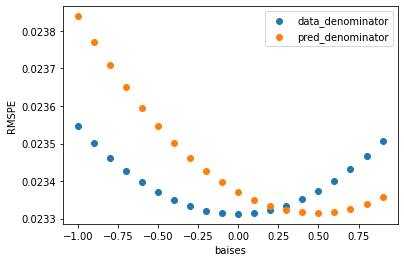

In [56]:
from ipywidgets import Label
np.random.seed(42)

data = np.random.normal(300, 3, 100000)
predictions = data + np.random.normal(0, 7, len(data))

def rmspe_data_dinominator(data, predictions): # balanced RMSPE Func = (mean((Yi - Y^i)/(Yi)) ** 2)) ** 0.5
  
  return np.mean(((data - predictions) / data) ** 2) ** 0.5 

def rmspe_pre_dinominator(data, predictions): # shifted RMSPE Func = (mean((Yi - Y^i)/(Y^i)) ** 2)) ** 0.5
 
  return np.mean(((data - predictions) / predictions) ** 2) ** 0.5  
 
baises = np.arange(-1, 1, 0.1)

plt.scatter(x=baises, 
            y=[rmspe_data_dinominator(data, predictions + bais)for bais in baises],
            Label='data_denominator')
plt.scatter(x=baises, 
            y=[rmspe_pre_dinominator(data, predictions + bais)for bais in baises], 
            Label='pred_denominator')

plt.legend()
plt.xlabel('baises')
plt.ylabel('RMSPE')




Building the model

In [57]:
import xgboost as xgb
# Because we divide sometimes with very smale numbers we do a log on the lables
# adding 1 to the label avoiding dividing by 0
dtrain = xgb.DMatrix(train_df[features], np.log1p(train_df['Sales']))
dval = xgb.DMatrix(val_df[features], np.log1p(val_df['Sales']))
dtest = xgb.DMatrix(train_df[features])

In [58]:
params = {
    'objective': 'reg:squarederror', # It is a tailor made objective (we optimize the MSE of the loged label)
    'eta': 0.05,
    'sees': 42,
    'subsemple': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 5
}

# We need to change the func to divide with a large num to get closer to 0
def rmspe_data_dinominator(data, predictions): # balanced RMSPE Func = (mean((Yi - Y^i)/(Yi)) ** 2)) ** 0.5
  
  return np.mean(((data - predictions) / np.where(data, data, 999999999)) ** 2) ** 0.5

def exp_rmspe(y_pred, y):
  y = np.expm1(y.get_label())
  y_pred = np.expm1(y_pred)
  return 'rmspe', rmspe_data_dinominator(y, y_pred)

xgb.train(params,
          dtrain,
          num_boost_round=100,
          evals=[(dval, 'val'), (dtrain, ' train')], # for early stoping we relay on the val.
          feval= exp_rmspe,
          verbose_eval=10)

[0]	val-rmse:7.36273	train-rmse:7.15019	val-rmspe:0.934312	train-rmspe:0.910004
[10]	val-rmse:4.42636	train-rmse:4.28538	val-rmspe:0.926073	train-rmspe:0.901705
[20]	val-rmse:2.66917	train-rmse:2.56992	val-rmspe:0.879065	train-rmspe:0.85421
[30]	val-rmse:1.61996	train-rmse:1.54464	val-rmspe:0.765095	train-rmspe:0.738652
[40]	val-rmse:0.992837	train-rmse:0.933285	val-rmspe:0.604478	train-rmspe:0.576085
[50]	val-rmse:0.624755	train-rmse:0.574195	val-rmspe:0.446933	train-rmspe:0.416673
[60]	val-rmse:0.405832	train-rmse:0.361617	val-rmspe:0.319981	train-rmspe:0.28925
[70]	val-rmse:0.27957	train-rmse:0.242479	val-rmspe:0.233347	train-rmspe:0.205912
[80]	val-rmse:0.207239	train-rmse:0.179758	val-rmspe:0.17977	train-rmspe:0.159802
[90]	val-rmse:0.167637	train-rmse:0.150056	val-rmspe:0.150729	train-rmspe:0.139621
[99]	val-rmse:0.149955	train-rmse:0.13745	val-rmspe:0.138746	train-rmspe:0.132436


In [59]:
ex.box(train_df, x='DayOfWeek', y='Sales')

Output hidden; open in https://colab.research.google.com to view.

Extracting some insights;                                                                     we can see that Sales in the interquarterly range,                           for monday are between 5000K-10000K, and for sunday is 0.

We can tell the model( by adding another featur 'sunday_sales' = 0 or the 'evereg_sales' for the week), and by that improve predictions.                  
This action also named "target encoding".

In [60]:
group_dow_per_store = (train_df.groupby(['Store', 'DayOfWeek'])['Sales'].
                       mean().rename('mean_slaes_per_dow'))

train_df = train_df.merge(group_dow_per_store, on=['Store', 'DayOfWeek'])

subset = train_df.loc[train_df.Store.isin(range(6))]

ex.box(subset, x='DayOfWeek', y='Sales', color='Store')

In the above box plot
- We can see the variance between the different stores, and it is reasonable,   
  because of buying patterrence, geograficale  differences etc.
- In store number 4, we notice relatively high sales all days of the week,      
  and small drop in sales can be noticed in the middle of the week.

we can use this weekly behavior of all the stores, as a feature and try to improve, our model.

In [61]:
# train_df = train_df.merge(group_dow_per_store, on=['Store', 'DayOfWeek'])
val_df = val_df.merge(group_dow_per_store, on=['Store', 'DayOfWeek'])
test_df = test_df.merge(group_dow_per_store, on=['Store', 'DayOfWeek'])


In [62]:
train_df.head().T

,0,1,2,3,4
Store,1,1,1,1,1
DayOfWeek,2,2,2,2,2
Date,2015-06-30 00:00:00,2015-06-23 00:00:00,2015-06-16 00:00:00,2015-06-09 00:00:00,2015-06-02 00:00:00
Sales,5735,3762,4852,4102,5450
Customers,568,447,503,485,590
Open,1,1,1,1,1
Promo,1,0,1,0,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0
StoreType,2,2,2,2,2


In [63]:
import xgboost as xgb
# Because we divide sometimes with very smale numbers we do a log on the lables
# adding 1 to the label avoiding dividing by 0
features.append('mean_slaes_per_dow')

dtrain = xgb.DMatrix(train_df[features], np.log1p(train_df['Sales']))
dval = xgb.DMatrix(val_df[features], np.log1p(val_df['Sales']))
dtest = xgb.DMatrix(train_df[features])

In [64]:
params = {
    'objective': 'reg:squarederror', # It is a tailor made objective (we optimize the MSE of the loged label)
    'eta': 0.05,
    'sees': 42,
    'subsemple': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 5
}

# We need to change the func to divide with a large num to get closer to 0
def rmspe_data_dinominator(data, predictions): # balanced RMSPE Func = (mean((Yi - Y^i)/(Yi)) ** 2)) ** 0.5
  
  return np.mean(((data - predictions) / np.where(data, data, 999999999)) ** 2) ** 0.5

def exp_rmspe(y_pred, y):
  y = np.expm1(y.get_label())
  y_pred = np.expm1(y_pred)
  return 'rmspe', rmspe_data_dinominator(y, y_pred)

xgb.train(params,
          dtrain,
          num_boost_round=100,
          evals=[(dval, 'val'), (dtrain, ' train')], # for early stoping we relay on the val.
          feval= exp_rmspe,
          verbose_eval=10)

[0]	val-rmse:7.36207	train-rmse:7.15017	val-rmspe:0.934312	train-rmspe:0.910005
[10]	val-rmse:4.42145	train-rmse:4.2833	val-rmspe:0.926091	train-rmspe:0.901744
[20]	val-rmse:2.66129	train-rmse:2.56704	val-rmspe:0.879136	train-rmspe:0.854546
[30]	val-rmse:1.61042	train-rmse:1.54095	val-rmspe:0.764887	train-rmspe:0.739394
[40]	val-rmse:0.980026	train-rmse:0.927982	val-rmspe:0.602699	train-rmspe:0.5767
[50]	val-rmse:0.605023	train-rmse:0.563753	val-rmspe:0.439817	train-rmspe:0.413872
[60]	val-rmse:0.383102	train-rmse:0.349878	val-rmspe:0.30804	train-rmspe:0.283767
[70]	val-rmse:0.252906	train-rmse:0.227579	val-rmspe:0.215473	train-rmspe:0.195519
[80]	val-rmse:0.179384	train-rmse:0.161438	val-rmspe:0.158243	train-rmspe:0.144226
[90]	val-rmse:0.139673	train-rmse:0.128422	val-rmspe:0.12704	train-rmspe:0.118962
[99]	val-rmse:0.121106	train-rmse:0.11391	val-rmspe:0.113352	train-rmspe:0.108573


# We have reduce our val error from val-rmspe:0.138746 to val-rmspe:0.113352                                                                          
# In large scale buisness it can translate to a significant amount